In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [3]:
image = Image.open("Dataset/Train/Fake/fake_66391.jpg")
width, height = image.size
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")

Width: 256 pixels
Height: 256 pixels


In [5]:
batch_size = 32
image_size = (256, 256)
train_generator = datagen.flow_from_directory(
    'MiniProject\Train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    'MiniProject\Validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 53995 images belonging to 2 classes.
Found 4697 images belonging to 2 classes.


In [6]:
data_dir_train = 'MiniProject\Train'
data_dir_val = 'MiniProject\Validation'
img_height = 256
img_width = 256

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  train_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67493 files belonging to 2 classes.
Using 53995 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67493 files belonging to 2 classes.
Using 13498 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['Fake', 'Real']

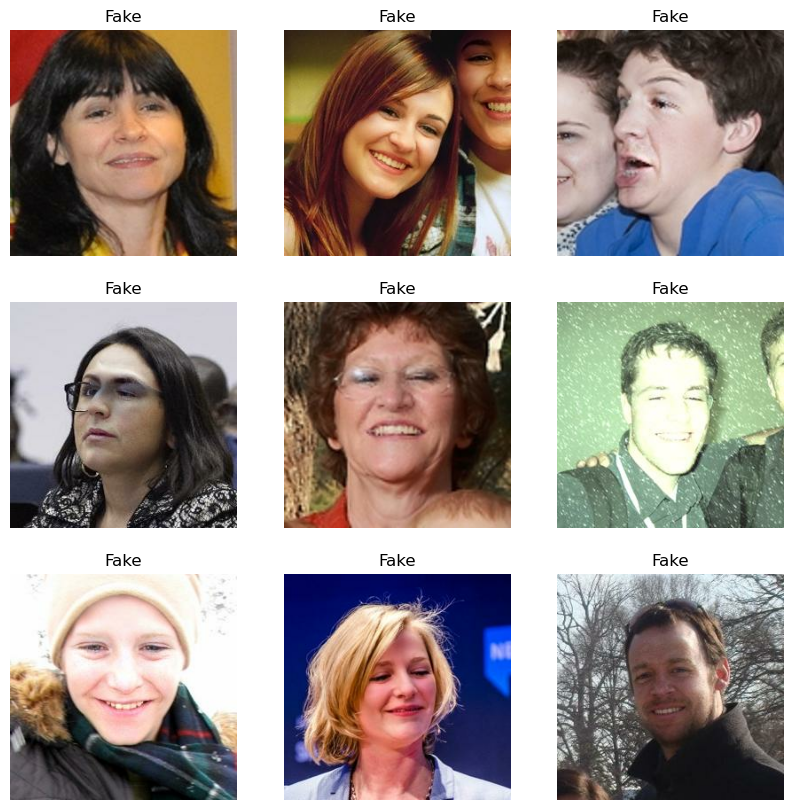

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
1688/1688 [==============================] - 1336s 716ms/step - loss: 0.4292 - accuracy: 0.7938 - val_loss: 0.3013 - val_accuracy: 0.8669
Epoch 2/5
1688/1688 [==============================] - 1093s 647ms/step - loss: 0.2254 - accuracy: 0.9060 - val_loss: 0.2277 - val_accuracy: 0.9055
Epoch 3/5
1688/1688 [==============================] - 1054s 625ms/step - loss: 0.1354 - accuracy: 0.9467 - val_loss: 0.2134 - val_accuracy: 0.9198
Epoch 4/5
1688/1688 [==============================] - 1066s 631ms/step - loss: 0.0780 - accuracy: 0.9699 - val_loss: 0.1786 - val_accuracy: 0.9338
Epoch 5/5
1688/1688 [==============================] - 1156s 685ms/step - loss: 0.0417 - accuracy: 0.9854 - val_loss: 0.2374 - val_accuracy: 0.9334


In [19]:
model.save('Deepfake_Detection.keras')

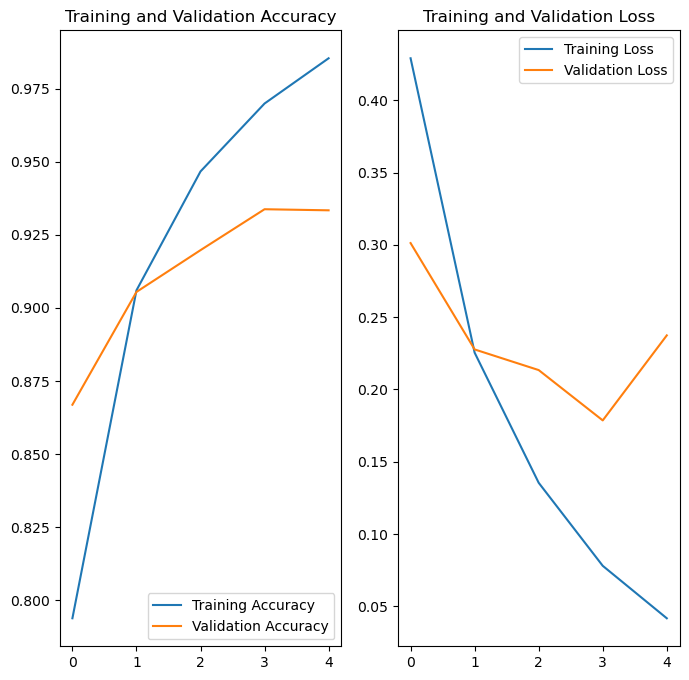

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()